In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
from PIL import Image

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # adjust if images are RGB
])

# Paths
train_folder = "../data/Training"
test_folder = "../data/Testing"

# Load datasets
train_ds = datasets.ImageFolder(root=train_folder, transform=transform)
test_ds = datasets.ImageFolder(root=test_folder, transform=transform)

# Data loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Class names
class_names = train_ds.classes
print("Classes:", class_names)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


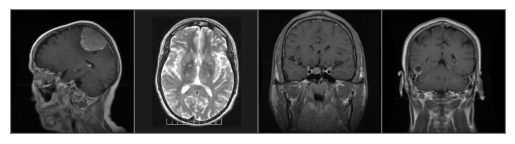

['meningioma', 'notumor', 'pituitary', 'glioma']


In [4]:
class_names = train_ds.classes

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Show sample batch
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print([class_names[l] for l in labels[:4]])

In [ ]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),  # input: 3x224x224
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x112x112

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x56x56

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64x28x28
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = BrainTumorCNN().to(device)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Simple training loop
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")
        
        # Validation accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'Validation Accuracy: {100 * correct / total:.2f}%')

train_model(model, train_loader, test_loader, epochs=10)


Epoch [1/10], Loss: 0.7530
Validation Accuracy: 80.09%
Epoch [2/10], Loss: 0.3732
Validation Accuracy: 85.43%
Epoch [3/10], Loss: 0.2418
Validation Accuracy: 92.07%
Epoch [4/10], Loss: 0.1504
Validation Accuracy: 93.44%
Epoch [5/10], Loss: 0.1062
Validation Accuracy: 95.58%
Epoch [6/10], Loss: 0.0605
Validation Accuracy: 94.66%
Epoch [7/10], Loss: 0.0599
Validation Accuracy: 95.19%
Epoch [8/10], Loss: 0.0443
Validation Accuracy: 95.96%
Epoch [9/10], Loss: 0.0312
Validation Accuracy: 96.72%
Epoch [10/10], Loss: 0.0224
Validation Accuracy: 96.26%


In [ ]:
#save model
torch.save(model.state_dict(), "../models/model.pth")